## SGD доработки

In [ ]:
import torch
from torch import nn
from torch import optim

import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Ссылка на датасет на каггл: https://www.kaggle.com/datasets/ashfakyeafi/glasses-classification-dataset/data

Ссылка на датасет на google drive: https://drive.google.com/file/d/1iC5c4pJwk-Wb07mP-Qr2tjcvJuRCnoOs

In [ ]:
!wget 'https://drive.google.com/uc?id=1iC5c4pJwk-Wb07mP-Qr2tjcvJuRCnoOs' -O glasses.zip

--2024-10-24 08:25:05--  https://drive.google.com/uc?id=1iC5c4pJwk-Wb07mP-Qr2tjcvJuRCnoOs
Resolving drive.google.com (drive.google.com)... 108.177.127.101, 108.177.127.138, 108.177.127.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1iC5c4pJwk-Wb07mP-Qr2tjcvJuRCnoOs [following]
--2024-10-24 08:25:05--  https://drive.usercontent.google.com/download?id=1iC5c4pJwk-Wb07mP-Qr2tjcvJuRCnoOs
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936892 (915K) [application/octet-stream]
Saving to: ‘glasses.zip’

glasses.zip         100%[===================>] 914.93K  --.-KB/s    in 0.03s   

2024-10-24 08:25:09 (33.4 MB/s)

In [ ]:
!unzip glasses.zip

Archive:  glasses.zip
   creating: train/
   creating: train/glasses/
  inflating: train/glasses/row-5-column-2.jpg  
  inflating: train/glasses/row-1-column-6.jpg  
  inflating: train/glasses/row-3-column-3.jpg  
  inflating: train/glasses/row-1-column-12.jpg  
  inflating: train/glasses/row-4-column-2.jpg  
  inflating: train/glasses/row-4-column-3.jpg  
  inflating: train/glasses/row-4-column-8.jpg  
  inflating: train/glasses/row-4-column-4.jpg  
  inflating: train/glasses/row-2-column-1.jpg  
  inflating: train/glasses/row-4-column-11.jpg  
  inflating: train/glasses/row-4-column-10.jpg  
  inflating: train/glasses/row-3-column-4.jpg  
  inflating: train/glasses/row-3-column-11.jpg  
  inflating: train/glasses/row-1-column-8.jpg  
  inflating: train/glasses/row-2-column-5.jpg  
  inflating: train/glasses/row-1-column-3.jpg  
  inflating: train/glasses/row-2-column-9.jpg  
  inflating: train/glasses/row-1-column-7.jpg  
  inflating: train/glasses/row-2-column-10.jpg  
  inflating: 

Нужно добавить преобразование изображений в тензоры. Для этого берем модуль [transforms](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
from torchvision.transforms import transforms

img_size = 64

transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop(img_size),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder

batch_size = 16

train_data = ImageFolder('/content/train', transform=transform)
test_data = ImageFolder('/content/validate', transform=transform)

classes = train_data.classes


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True)

noglasses


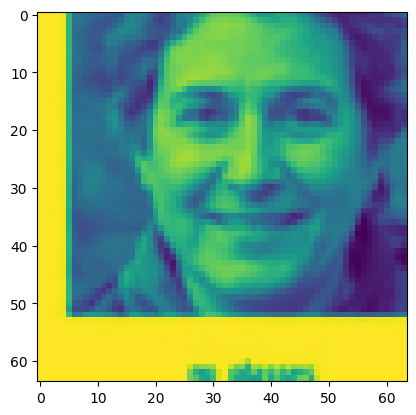

In [ ]:
import matplotlib.pyplot as plt


torch.manual_seed(1)
ind = 3
for data, y in train_loader:
    plt.imshow(data[ind].permute(1, 2, 0))
    print(classes[y[ind]])
    break

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Net(img_size * img_size, 1000, 2)
net = net.to(device)
net

Net(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
  (relu): ReLU()
)

In [ ]:
import torchsummary
torchsummary.summary(net, (img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 4096]               0
            Linear-2                 [-1, 1000]       4,097,000
              ReLU-3                 [-1, 1000]               0
            Linear-4                  [-1, 500]         500,500
              ReLU-5                  [-1, 500]               0
            Linear-6                    [-1, 2]           1,002
Total params: 4,598,502
Trainable params: 4,598,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 17.54
Estimated Total Size (MB): 17.61
----------------------------------------------------------------


In [ ]:
example = data[:1].to(device)
pred = net(example)
pred

tensor([[ 0.0710, -0.0439]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Обучение модели с разными оптимизаторами

In [ ]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
from IPython.display import clear_output

def train(model, crit, optim,
          train_loader, test_loader,
          num_epochs=10, plot=False):

    history = {'loss': {'train': [], 'test': []},
               'acc': {'train': [], 'test': []}}

    for epoch in range(num_epochs):
        train_loss = 0
        train_items, train_correct = 0, 0
        val_loss = 0
        val_items, val_correct = 0, 0


        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()


            train_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            train_items += len(labels)
            train_correct += (y_pred == labels).sum().item()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_loader)
        train_acc = train_correct / train_items
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = crit(outputs, y_batch)
            val_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            val_items += len(y_batch)
            val_correct += (y_pred == y_batch).sum().item()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_loader)
        val_acc = val_correct / val_items
        history['loss']['test'].append(val_loss)
        history['acc']['test'].append(val_acc)

        if plot:
            clear_output()
            plot_learning_curves(history)

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} of {num_epochs}")
            print(f"  train loss: {train_loss:.3f}" \
                  f"  test loss: {val_loss:.3f}"  \
                  f"  train acc: {train_acc * 100:.2f}%" \
                  f"  test acc: {val_acc * 100:.2f}%")


    return model, history

In [ ]:
from torch import optim

optims = [

]

nets = {}

for optimizer_name in ['SGD', 'RMSProp', 'Adam']:
    net = Net(img_size * img_size, 1000, 2)
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(net.parameters(), lr=0.001)
    else:
        optimizer = optim.Adam(net.parameters(), lr=0.001)

    print('_'*10, optimizer_name)
    net, history = train(
        net, criterion, optimizer,
        train_loader, test_loader,
        num_epochs=50,
    )

    nets[optimizer_name] = (net, history)

__________ SGD
Epoch 1 of 50
  train loss: 0.692  test loss: 0.688  train acc: 50.00%  test acc: 50.00%
Epoch 11 of 50
  train loss: 0.681  test loss: 0.685  train acc: 68.27%  test acc: 67.50%
Epoch 21 of 50
  train loss: 0.675  test loss: 0.674  train acc: 64.42%  test acc: 62.50%
Epoch 31 of 50
  train loss: 0.671  test loss: 0.667  train acc: 64.42%  test acc: 57.50%
Epoch 41 of 50
  train loss: 0.666  test loss: 0.667  train acc: 62.50%  test acc: 62.50%
__________ RMSProp
Epoch 1 of 50
  train loss: 35.426  test loss: 1.577  train acc: 50.00%  test acc: 50.00%
Epoch 11 of 50
  train loss: 0.724  test loss: 0.683  train acc: 54.81%  test acc: 57.50%
Epoch 21 of 50
  train loss: 0.642  test loss: 0.717  train acc: 71.15%  test acc: 52.50%
Epoch 31 of 50
  train loss: 0.596  test loss: 0.618  train acc: 67.31%  test acc: 67.50%
Epoch 41 of 50
  train loss: 0.582  test loss: 0.830  train acc: 70.19%  test acc: 70.00%
__________ Adam
Epoch 1 of 50
  train loss: 1.022  test loss: 0.884

In [ ]:
nets.keys()

dict_keys(['SGD', 'RMSProp', 'Adam'])

SGD


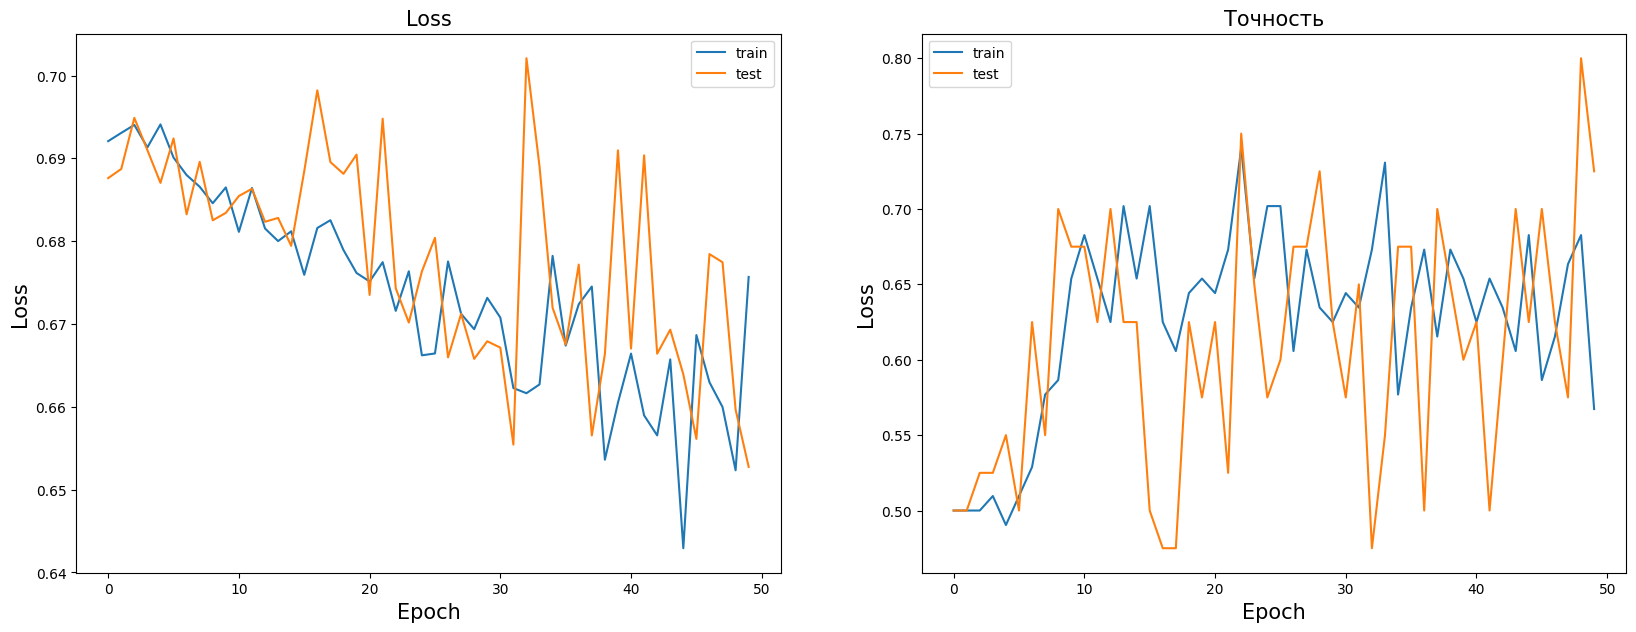

RMSProp


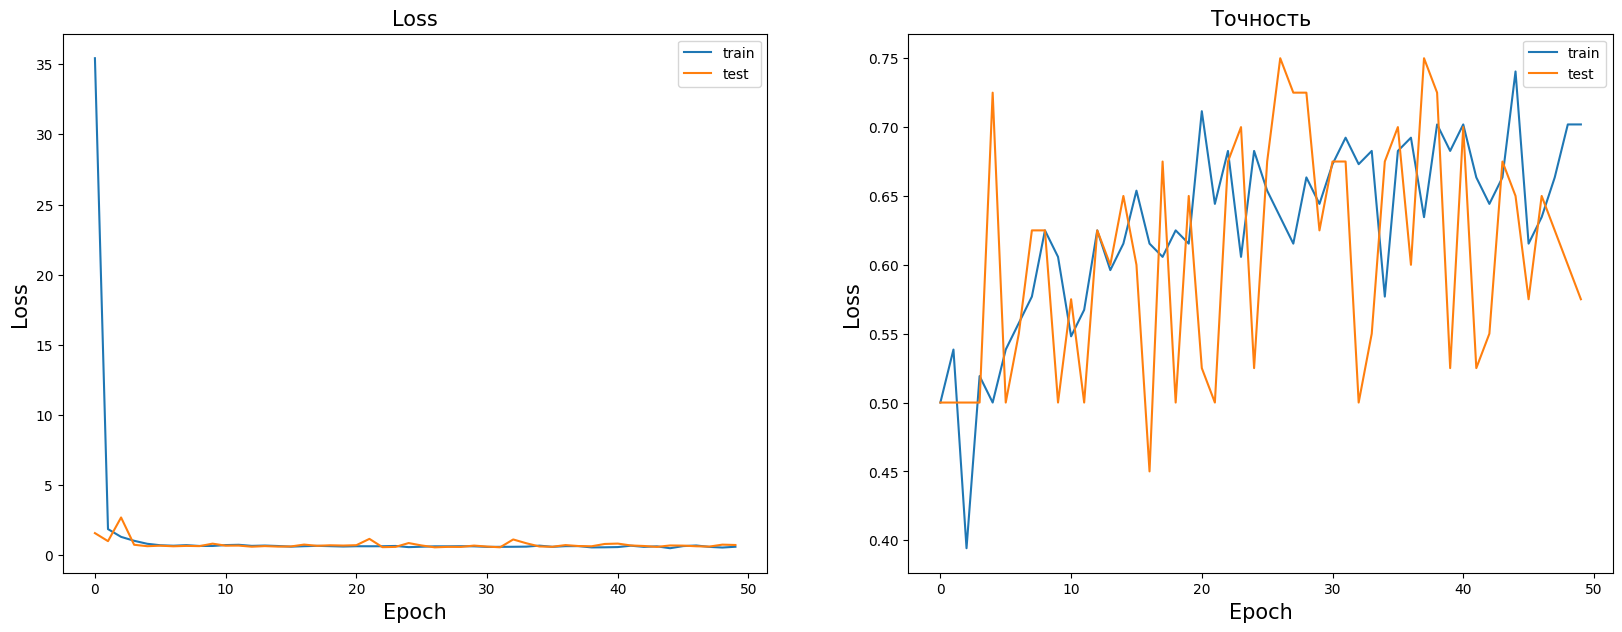

Adam


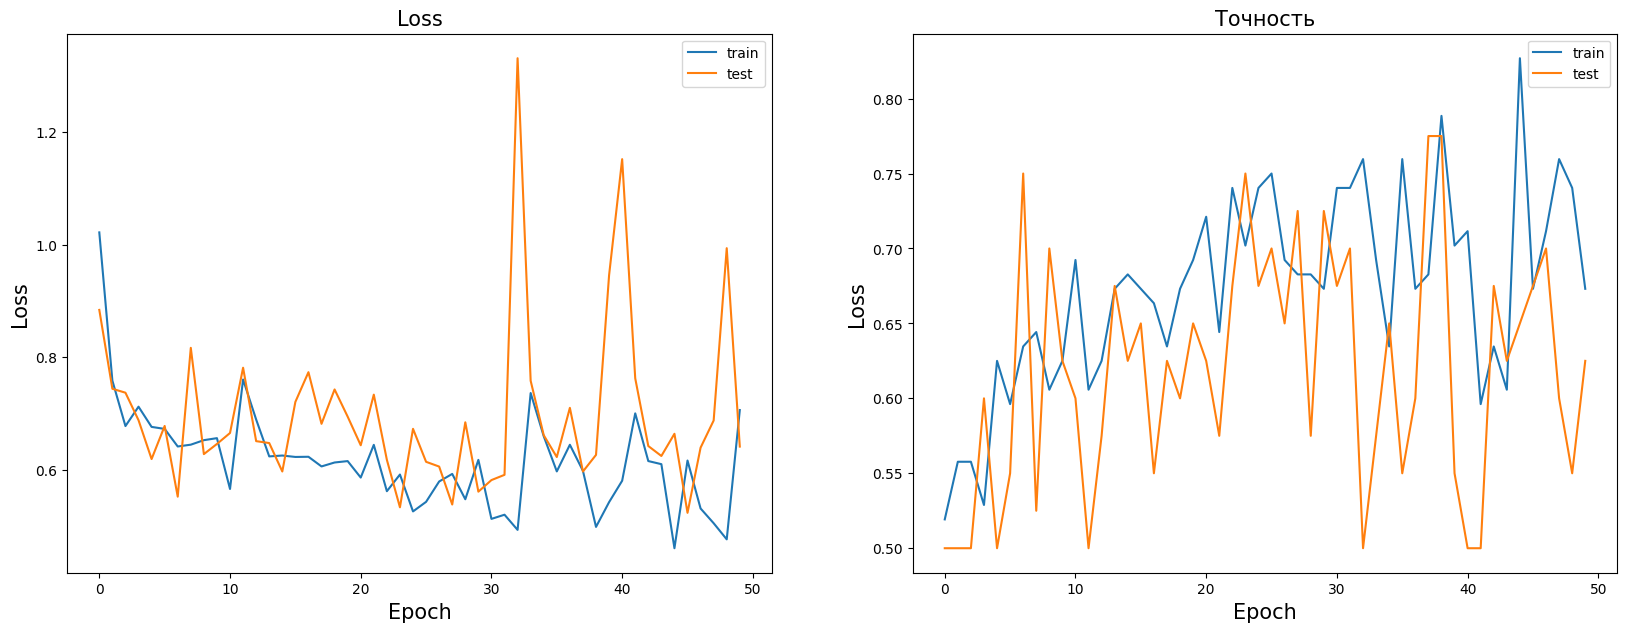

In [ ]:
for name, net_data in nets.items():
    print(name)
    history = net_data[1]
    plot_learning_curves(history)
    plt.show()

### Обучение модели с разными шедулерами

In [ ]:
from IPython.display import clear_output

def train(model, crit, optim,
          train_loader, test_loader,
          scheduler=None,  ## добавили
          num_epochs=10,
          plot=False):

    history = {'loss': {'train': [], 'test': []},
               'acc': {'train': [], 'test': []}}

    for epoch in range(num_epochs):
        train_loss = 0
        train_items, train_correct = 0, 0
        val_loss = 0
        val_items, val_correct = 0, 0

        # на каждой "эпохе" делаем полный проход по данным
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()


            train_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            train_items += len(labels)
            train_correct += (y_pred == labels).sum().item()

        ## добавили
        if scheduler:
            scheduler.step()
            if epoch % 10 == 0:
                print(scheduler.get_last_lr())
        ## добавили


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_loader)
        train_acc = train_correct / train_items
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = crit(outputs, y_batch)
            val_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            val_items += len(y_batch)
            val_correct += (y_pred == y_batch).sum().item()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_loader)
        val_acc = val_correct / val_items
        history['loss']['test'].append(val_loss)
        history['acc']['test'].append(val_acc)

        if plot:
            clear_output()
            plot_learning_curves(history)

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} of {num_epochs}")
            print(f"  train loss: {train_loss:.3f}" \
                  f"  test loss: {val_loss:.3f}"  \
                  f"  train acc: {train_acc * 100:.2f}%" \
                  f"  test acc: {val_acc * 100:.2f}%")


    return model, history

In [ ]:
from torch.optim import lr_scheduler


nets = {}

for scheduler_name in ['ExponentialLR', 'CyclicLR', 'LinearLR']:
    net = Net(img_size * img_size, 1000, 2)
    net = net.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)


    if scheduler_name == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_name == 'CyclicLR':
        scheduler = lr_scheduler.CyclicLR(
            optimizer, base_lr=0.00001, max_lr=0.0005, step_size_up=10, mode="triangular2"
        )
    else:
        scheduler = lr_scheduler.LinearLR(
            optimizer, start_factor=0.9, end_factor=0.2, total_iters=40
        )


    print('_'*10, scheduler_name)
    net, history = train(
        net, criterion, optimizer,
        train_loader, test_loader,
        num_epochs=50,
        scheduler=scheduler
    )

    nets[scheduler_name] = (net, history)

__________ ExponentialLR
[0.0009000000000000001]
Epoch 1 of 50
  train loss: 1.022  test loss: 0.884  train acc: 51.92%  test acc: 50.00%
[0.00031381059609000004]
Epoch 11 of 50
  train loss: 0.560  test loss: 0.681  train acc: 69.23%  test acc: 57.50%
[0.00010941898913151243]
Epoch 21 of 50
  train loss: 0.551  test loss: 0.573  train acc: 71.15%  test acc: 65.00%
[3.8152042447694614e-05]
Epoch 31 of 50
  train loss: 0.548  test loss: 0.594  train acc: 71.15%  test acc: 65.00%
[1.3302794647291146e-05]
Epoch 41 of 50
  train loss: 0.572  test loss: 0.614  train acc: 69.23%  test acc: 67.50%
__________ CyclicLR
[5.900000000000004e-05]
Epoch 1 of 50
  train loss: 0.692  test loss: 0.687  train acc: 48.08%  test acc: 52.50%
[0.00045099999999999996]
Epoch 11 of 50
  train loss: 0.615  test loss: 0.650  train acc: 66.35%  test acc: 62.50%
[3.449999999999991e-05]
Epoch 21 of 50
  train loss: 0.548  test loss: 0.590  train acc: 71.15%  test acc: 65.00%
[0.00023050000000000007]
Epoch 31 of 50


In [ ]:
nets.keys()

dict_keys(['ExponentialLR', 'CyclicLR', 'LinearLR'])

ExponentialLR


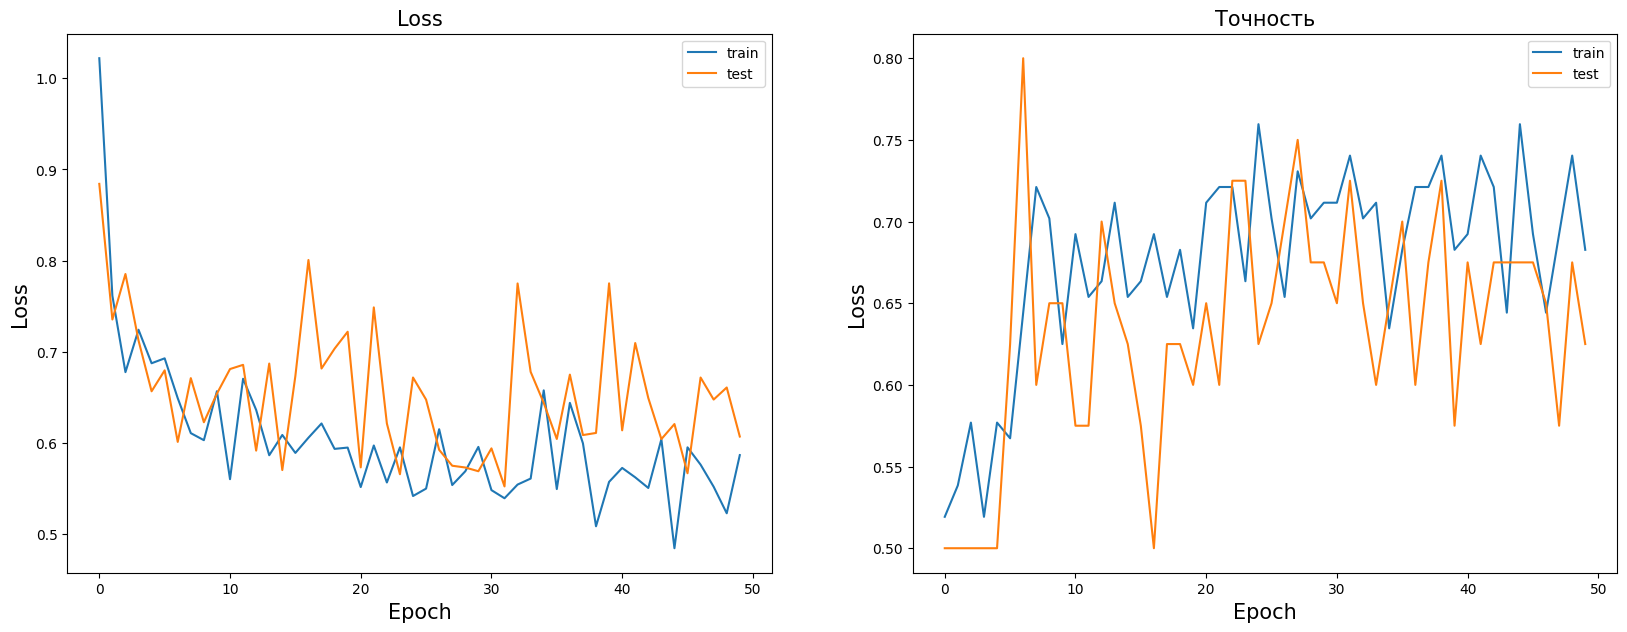

CyclicLR


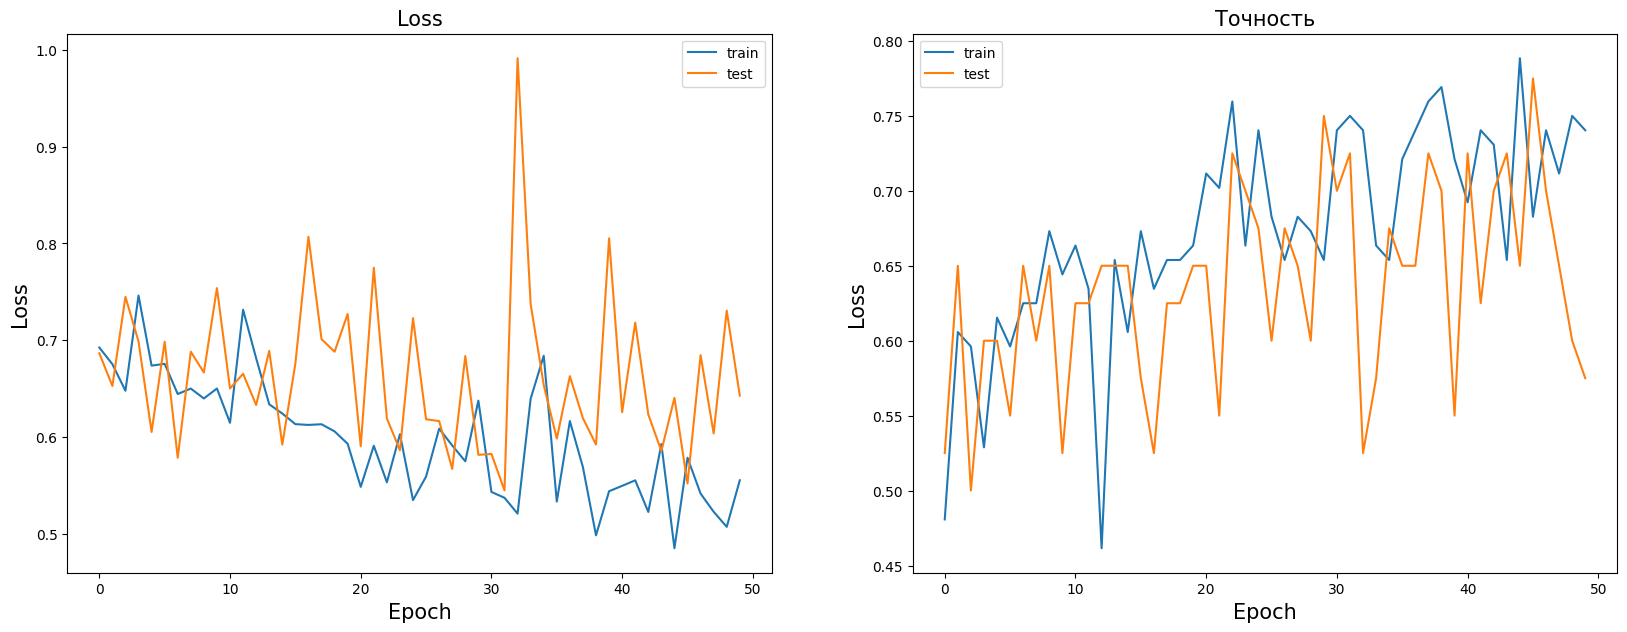

LinearLR


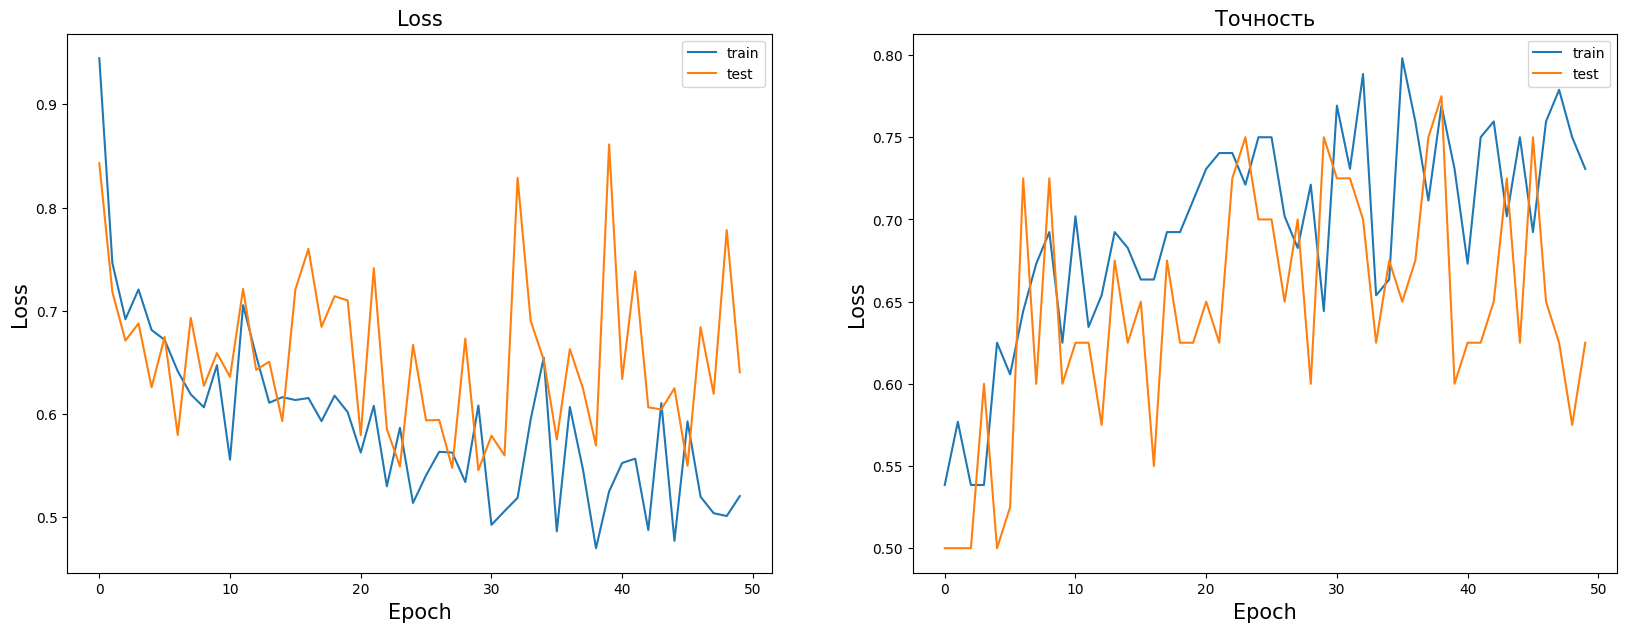

In [ ]:
for name, net_data in nets.items():
    print(name)
    history = net_data[1]
    plot_learning_curves(history)
    plt.show()

### Обучение с Dropout и BatchNorm

Обсуждение на тему, в каком порядке ставить BatchNorm с Dropout можно почитать [здесь](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)


In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Net(img_size * img_size, 1000, 2)
net = net.to(device)
net

Net(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
import torchsummary
torchsummary.summary(net, (img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 4096]               0
            Linear-2                 [-1, 1000]       4,097,000
       BatchNorm1d-3                 [-1, 1000]           2,000
              ReLU-4                 [-1, 1000]               0
           Dropout-5                 [-1, 1000]               0
            Linear-6                  [-1, 500]         500,500
       BatchNorm1d-7                  [-1, 500]           1,000
              ReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
             ReLU-10                  [-1, 500]               0
           Linear-11                    [-1, 2]           1,002
Total params: 4,601,502
Trainable params: 4,601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

noglasses


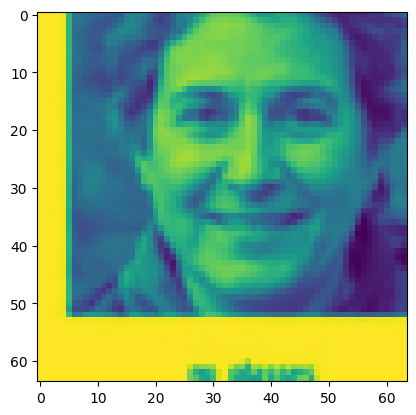

In [ ]:
import matplotlib.pyplot as plt


torch.manual_seed(1)
ind = 3
for data, y in train_loader:
    plt.imshow(data[ind].permute(1, 2, 0))
    print(classes[y[ind]])
    break

In [ ]:
example = data[:5].to(device)
pred = net(example)
pred

tensor([[ 0.2133,  0.1543],
        [ 0.1527, -0.7005],
        [ 0.0044, -0.1107],
        [-0.2756, -0.4023],
        [ 0.7034,  0.0274]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
from IPython.display import clear_output

def train(model, crit, optim,
          train_loader, test_loader,
          scheduler=None, num_epochs=10,
          plot=False):

    history = {'loss': {'train': [], 'test': []},
               'acc': {'train': [], 'test': []}}

    for epoch in range(num_epochs):
        train_loss = 0
        train_items, train_correct = 0, 0
        val_loss = 0
        val_items, val_correct = 0, 0

        ## добавили. устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()


            train_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            train_items += len(labels)
            train_correct += (y_pred == labels).sum().item()

        if scheduler:
            scheduler.step()
            if epoch % 10 == 0:
                print(scheduler.get_last_lr())

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_loader)
        train_acc = train_correct / train_items
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        ## добавили. устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = crit(outputs, y_batch)
            val_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            val_items += len(y_batch)
            val_correct += (y_pred == y_batch).sum().item()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_loader)
        val_acc = val_correct / val_items
        history['loss']['test'].append(val_loss)
        history['acc']['test'].append(val_acc)

        if plot:
            clear_output()
            plot_learning_curves(history)

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} of {num_epochs}")
            print(f"  train loss: {train_loss:.3f}" \
                  f"  test loss: {val_loss:.3f}"  \
                  f"  train acc: {train_acc * 100:.2f}%" \
                  f"  test acc: {val_acc * 100:.2f}%")


    return model, history

[5.900000000000004e-05]
Epoch 1 of 50
  train loss: 0.728  test loss: 0.685  train acc: 49.04%  test acc: 55.00%
[0.00045099999999999996]
Epoch 11 of 50
  train loss: 0.496  test loss: 1.620  train acc: 70.19%  test acc: 57.50%
[3.449999999999991e-05]
Epoch 21 of 50
  train loss: 0.429  test loss: 0.517  train acc: 80.77%  test acc: 75.00%
[0.00023050000000000007]
Epoch 31 of 50
  train loss: 0.388  test loss: 0.468  train acc: 81.73%  test acc: 80.00%
[2.2249999999999958e-05]
Epoch 41 of 50
  train loss: 0.303  test loss: 0.744  train acc: 83.65%  test acc: 70.00%


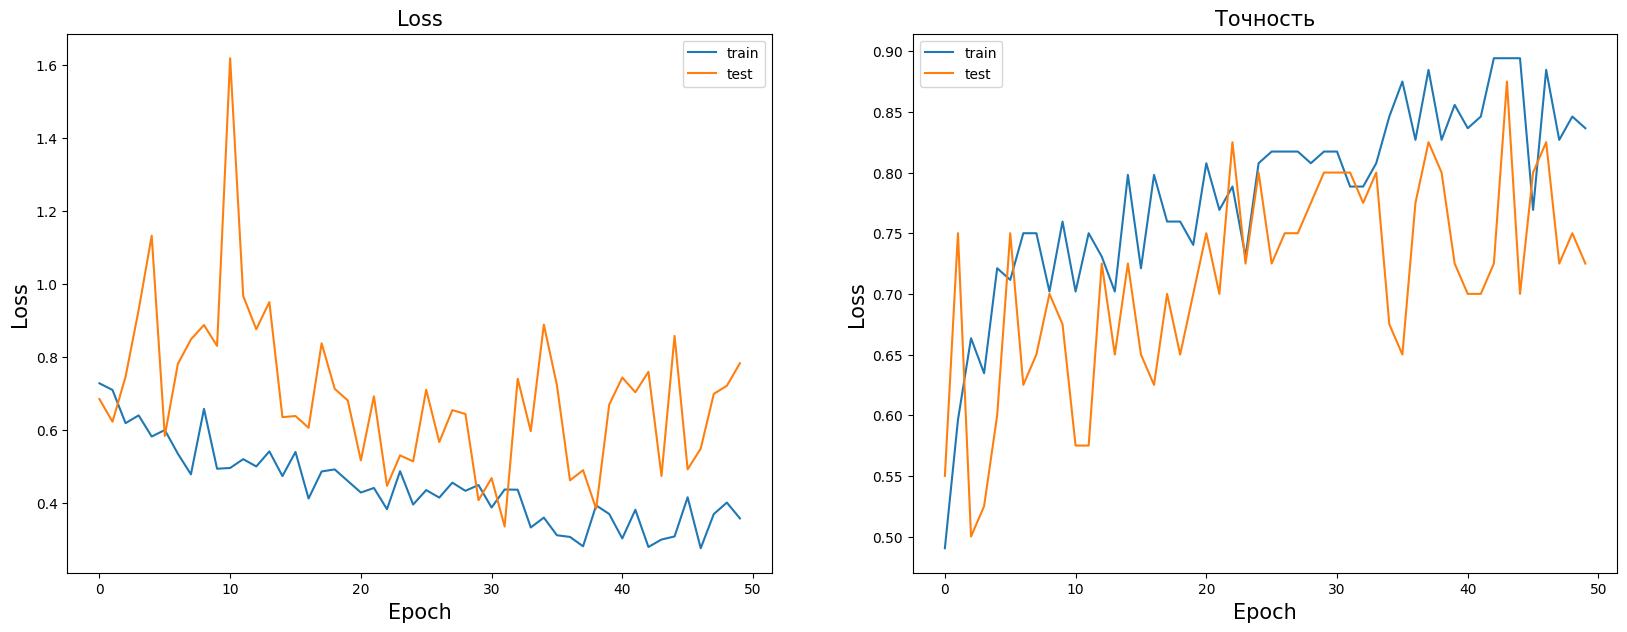

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(
        optimizer, base_lr=0.00001, max_lr=0.0005, step_size_up=10, mode="triangular2"
    )


net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50,
    scheduler=scheduler
)

plot_learning_curves(history)

### Аугментации

Нужно добавить преобразование изображений в тензоры. Для этого берем модуль [transforms](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
from torchvision.transforms import transforms


img_size = 64
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop(img_size),
    transforms.RandomChoice([
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.RandomRotation(25),
    ]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomAutocontrast(0.5),
    transforms.Grayscale(),
    transforms.ToTensor()
])

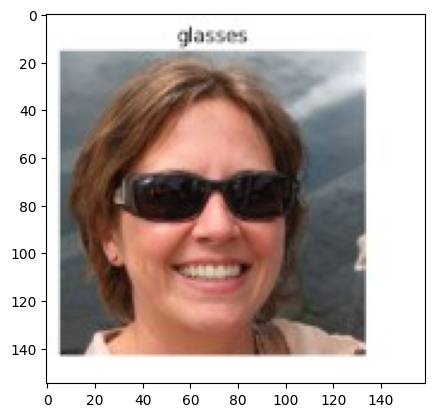

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


torch.manual_seed(0)


orig_img = Image.open('/content/train/glasses/row-1-column-1.jpg')
plt.imshow(orig_img)

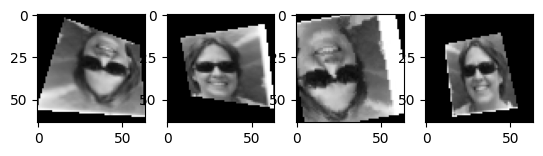

In [ ]:
transformed_imgs = [transform(orig_img) for _ in range(4)]

fig, ax = plt.subplots(1, 4)
for i, img in enumerate(transformed_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap='gray')

In [ ]:
from torchvision.datasets import ImageFolder

batch_size = 16

train_data = ImageFolder('/content/train', transform=transform)
test_data = ImageFolder('/content/validate', transform=transform)

classes = train_data.classes


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True)

noglasses


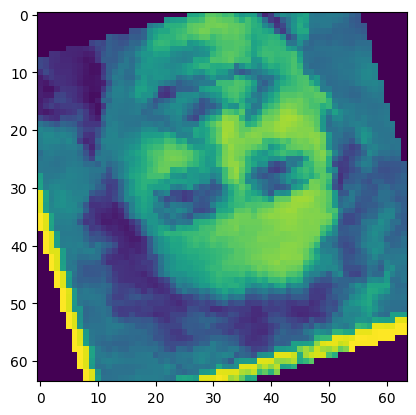

In [ ]:
import matplotlib.pyplot as plt


torch.manual_seed(1)
ind = 3
for data, y in train_loader:
    plt.imshow(data[ind].permute(1, 2, 0))
    print(classes[y[ind]])
    break

In [ ]:
net = Net(img_size * img_size, 1000, 2)
net = net.to(device)
net

Net(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

[5.900000000000004e-05]
Epoch 1 of 50
  train loss: 0.712  test loss: 0.689  train acc: 54.81%  test acc: 55.00%
[0.00045099999999999996]
Epoch 11 of 50
  train loss: 0.830  test loss: 0.689  train acc: 47.12%  test acc: 55.00%
[3.449999999999991e-05]
Epoch 21 of 50
  train loss: 0.623  test loss: 0.663  train acc: 66.35%  test acc: 62.50%
[0.00023050000000000007]
Epoch 31 of 50
  train loss: 0.676  test loss: 0.769  train acc: 56.73%  test acc: 52.50%
[2.2249999999999958e-05]
Epoch 41 of 50
  train loss: 0.699  test loss: 0.550  train acc: 60.58%  test acc: 80.00%


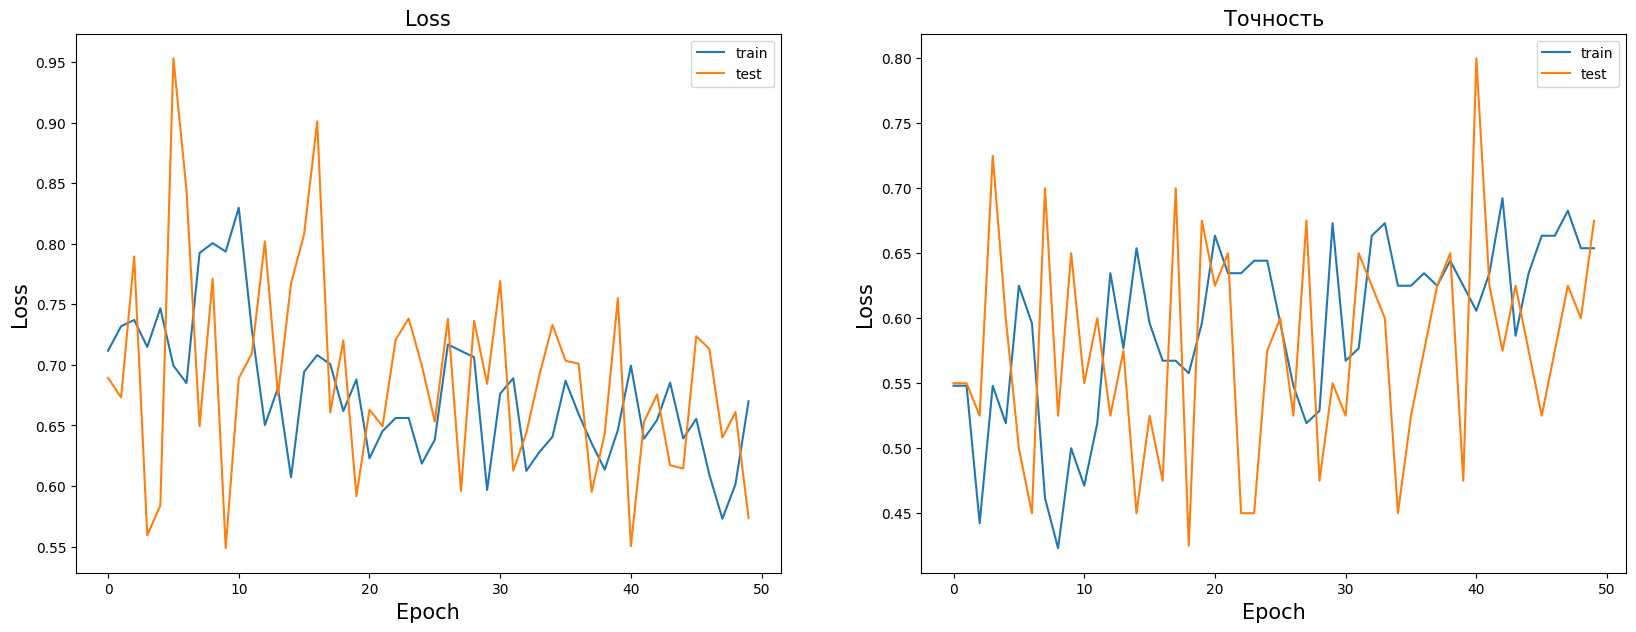

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(
        optimizer, base_lr=0.00001, max_lr=0.0005, step_size_up=10, mode="triangular2"
    )


net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50,
    scheduler=scheduler
)

plot_learning_curves(history)

#### 🧠 Упражнение. Плохие аугментации

1. Примените к данным "плохие" аугментации, при которых теряется суть изображений, визуализируйте их

In [ ]:
from torchvision.transforms import transforms


img_size = 64
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop(img_size),
    ...
    transforms.Grayscale(),
    transforms.ToTensor()
])

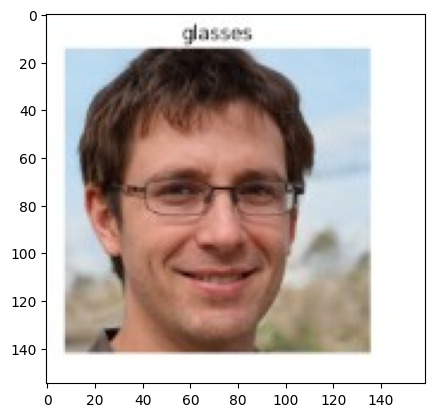

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


orig_img = Image.open('/content/train/glasses/row-1-column-4.jpg')
plt.imshow(orig_img)

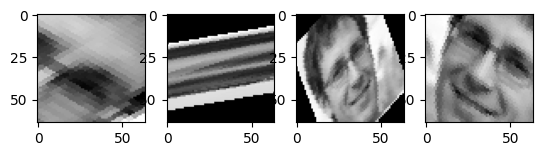

In [ ]:
transformed_imgs = ...

fig, ax = plt.subplots(1, 4)
for i, img in enumerate(transformed_imgs):
    ax[i].imshow(..., cmap='gray')

2. Создайте объект ImageFolder для тренировочной и тестовой выборок

In [ ]:
from torchvision.datasets import ImageFolder

batch_size = 16

train_data = ImageFolder(...)
test_data = ImageFolder(...)

classes = train_data.classes


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True)

noglasses


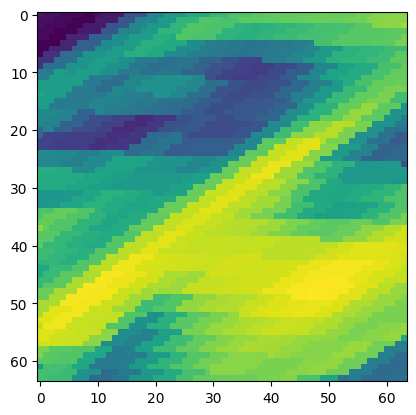

In [ ]:
import matplotlib.pyplot as plt


torch.manual_seed(1)
ind = 3
for data, y in train_loader:
    plt.imshow(data[ind].permute(1, 2, 0))
    print(classes[y[ind]])
    break

3. Создайте сеть на 1000 скрытых нейронов

In [ ]:
net = Net(...)
net = net.to(device)
net

Net(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

4. Обучите нейросеть с шедулером CyclicLR, визуализируйте изменение ошибки

[5.900000000000004e-05]
Epoch 1 of 100
  train loss: 0.690  test loss: 0.691  train acc: 51.92%  test acc: 57.50%
[0.00045099999999999996]
Epoch 11 of 100
  train loss: 0.646  test loss: 0.747  train acc: 61.54%  test acc: 47.50%
[3.449999999999991e-05]
Epoch 21 of 100
  train loss: 0.723  test loss: 0.569  train acc: 56.73%  test acc: 62.50%
[0.00023050000000000007]
Epoch 31 of 100
  train loss: 0.711  test loss: 0.621  train acc: 63.46%  test acc: 55.00%
[2.2249999999999958e-05]
Epoch 41 of 100
  train loss: 0.653  test loss: 0.712  train acc: 58.65%  test acc: 45.00%
[0.00012025000000000004]
Epoch 51 of 100
  train loss: 0.696  test loss: 0.665  train acc: 51.92%  test acc: 55.00%
[1.612499999999998e-05]
Epoch 61 of 100
  train loss: 0.684  test loss: 0.666  train acc: 61.54%  test acc: 65.00%
[6.512500000000002e-05]
Epoch 71 of 100
  train loss: 0.680  test loss: 0.627  train acc: 62.50%  test acc: 65.00%
[1.3062499999999989e-05]
Epoch 81 of 100
  train loss: 0.640  test loss: 0.64

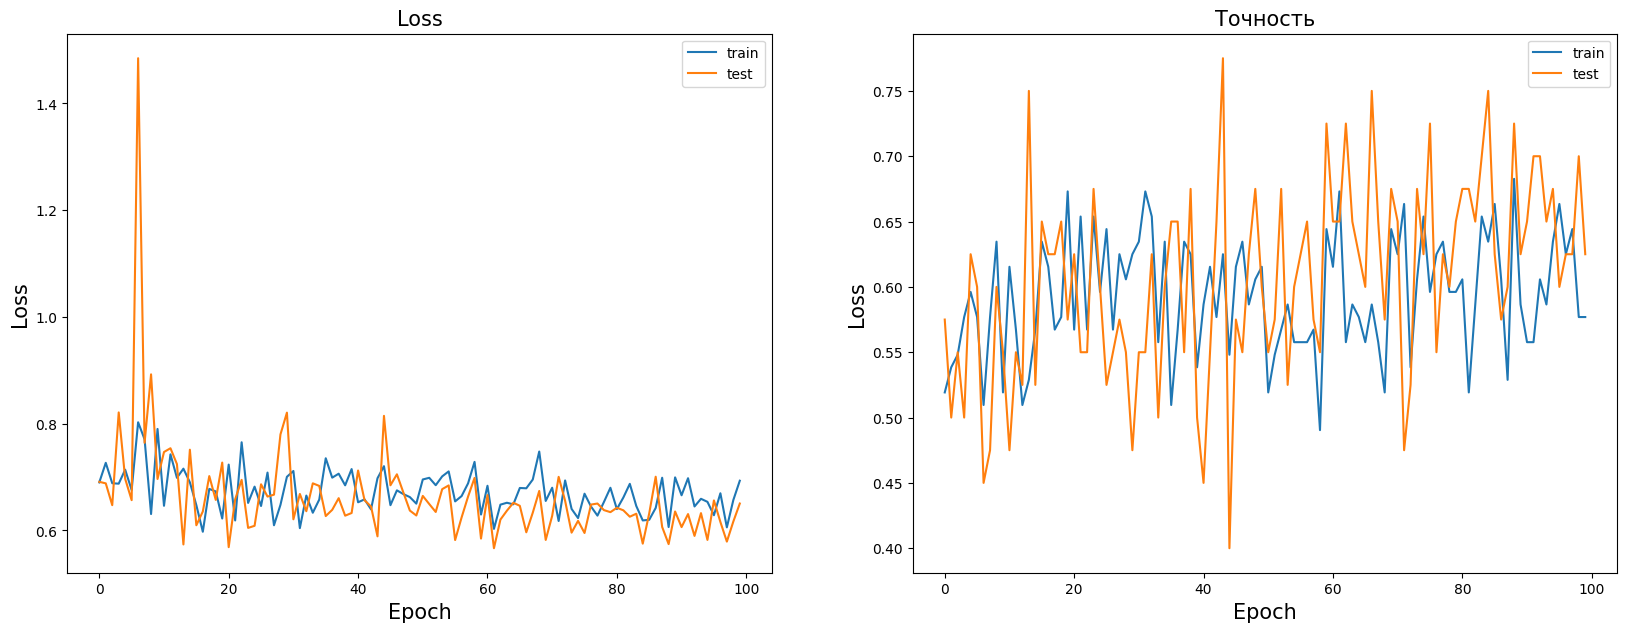

In [ ]:
criterion = ...
optimizer = ...
scheduler = ...


net, history = train(
    ...
)

plot_learning_curves(history)

##### 🧠 Упражнение (ответ). Плохие аугментации

1. Примените к данным "плохие" аугментации, при которых теряется суть изображений, визуализируйте их

In [ ]:
from torchvision.transforms import transforms


img_size = 64
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomAffine(
        degrees=50,
        scale=(1, 4),
        shear=100
    ),
    transforms.Grayscale(),
    transforms.ToTensor()
])

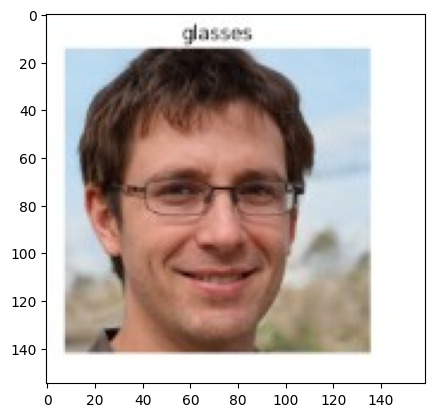

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


orig_img = Image.open('/content/train/glasses/row-1-column-4.jpg')
plt.imshow(orig_img)

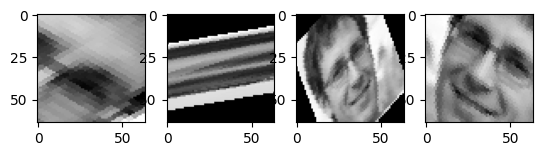

In [ ]:
transformed_imgs = [transform(orig_img) for _ in range(4)]

fig, ax = plt.subplots(1, 4)
for i, img in enumerate(transformed_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap='gray')

2. Создайте объект ImageFolder для тренировочной и тестовой выборок

In [ ]:
from torchvision.datasets import ImageFolder

batch_size = 16

train_data = ImageFolder('/content/train', transform=transform)
test_data = ImageFolder('/content/validate', transform=transform)

classes = train_data.classes


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True)

noglasses


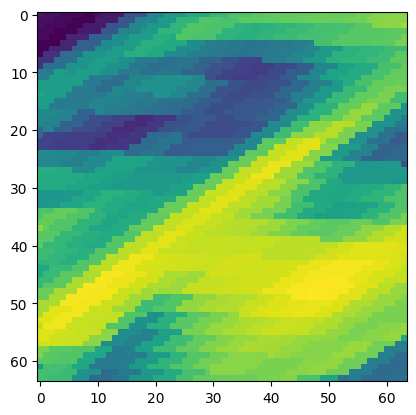

In [ ]:
import matplotlib.pyplot as plt


torch.manual_seed(1)
ind = 3
for data, y in train_loader:
    plt.imshow(data[ind].permute(1, 2, 0))
    print(classes[y[ind]])
    break

3. Создайте сеть на 1000 скрытых нейронов

In [ ]:
net = Net(img_size * img_size, 1000, 2)
net = net.to(device)
net

Net(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

4. Обучите нейросеть с шедулером CyclicLR, визуализируйте изменение ошибки

[5.900000000000004e-05]
Epoch 1 of 100
  train loss: 0.690  test loss: 0.691  train acc: 51.92%  test acc: 57.50%
[0.00045099999999999996]
Epoch 11 of 100
  train loss: 0.646  test loss: 0.747  train acc: 61.54%  test acc: 47.50%
[3.449999999999991e-05]
Epoch 21 of 100
  train loss: 0.723  test loss: 0.569  train acc: 56.73%  test acc: 62.50%
[0.00023050000000000007]
Epoch 31 of 100
  train loss: 0.711  test loss: 0.621  train acc: 63.46%  test acc: 55.00%
[2.2249999999999958e-05]
Epoch 41 of 100
  train loss: 0.653  test loss: 0.712  train acc: 58.65%  test acc: 45.00%
[0.00012025000000000004]
Epoch 51 of 100
  train loss: 0.696  test loss: 0.665  train acc: 51.92%  test acc: 55.00%
[1.612499999999998e-05]
Epoch 61 of 100
  train loss: 0.684  test loss: 0.666  train acc: 61.54%  test acc: 65.00%
[6.512500000000002e-05]
Epoch 71 of 100
  train loss: 0.680  test loss: 0.627  train acc: 62.50%  test acc: 65.00%
[1.3062499999999989e-05]
Epoch 81 of 100
  train loss: 0.640  test loss: 0.64

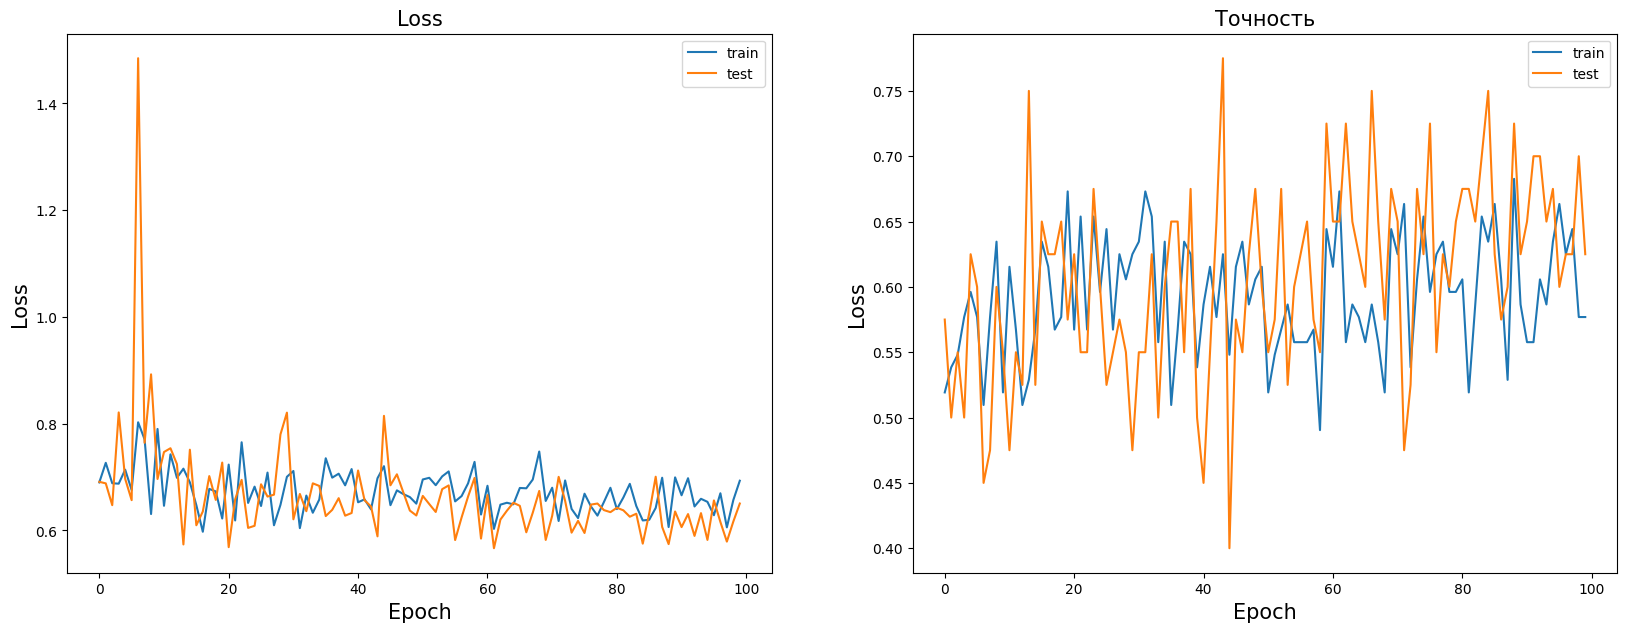

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(
        optimizer, base_lr=0.00001, max_lr=0.0005, step_size_up=10, mode="triangular2"
    )


net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=100,
    scheduler=scheduler
)

plot_learning_curves(history)

## Дополнительные материалы
1. Оптимизаторы и шедулеры https://pytorch.org/docs/stable/optim.html
2. Аугментации в модуле transforms https://pytorch.org/vision/stable/transforms.html
3. Порядок слоев BatchNorm с Dropout https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/
